# 1-hop neighbor aggregates

Here, we add to the node-level dataset 1-hop neighbor aggregates of centrality measures and normalizes all of these features within each sentence. We also tried this dataset as our base in our main models, but the benefit we gained in accuracy was very minimal (1%-2%) and it outweighed the performance drop they generated. The notebook also includes a utility to visualize example trees.

In [16]:
import pandas as pd
import networkx as nx
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
# raw training data (w/ edgelists)
train = pd.read_csv('../data/train.csv')
train['edgelist'] = train['edgelist'].apply(ast.literal_eval)

In [4]:
# Load normalized, expanded node‐level features
expanded = pd.read_csv('../data/normalized_expanded_train.csv')

In [5]:
def plot_tree(edgelist, root, title=None):
    """
    Draws an undirected tree from its edgelist, with the root node in red.
    """
    T = nx.from_edgelist(edgelist)
    # layout: spring for generality; for strict tree layout, consider graphviz with nx_agraph
    pos = nx.spring_layout(T)
    # color nodes: red for root, skyblue otherwise
    node_colors = ['red' if node == root else 'skyblue' for node in T.nodes()]
    plt.figure(figsize=(6, 6))
    nx.draw(T, pos,
            with_labels=True,
            node_color=node_colors,
            node_size=300,
            edge_color='gray',
            font_size=8)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

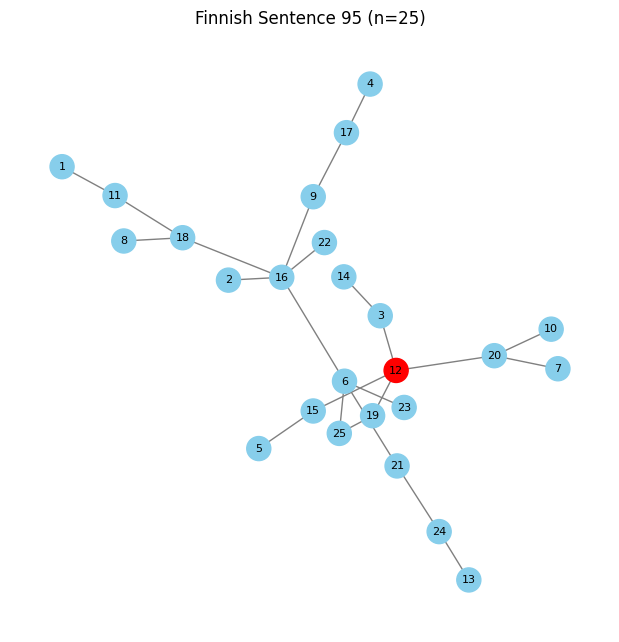

In [6]:
# Find graph based on the row nr. of train (used for exploring numbers)
e0 = train.iloc[546]
plot_tree(e0.edgelist, e0.root,
          title=f"{e0.language} Sentence {e0.sentence} (n={e0.n})")

In [19]:
# load precomputed node‑level features
columns = [
    'language', 'sentence', 'vertex', 'n',
    'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank',
    'eigenvector', 'katz', 'information', 'current_flow_betweeness',
    'percolation', 'second_order', 'laplacian', 'is_root'
]
df_cent = pd.read_csv('../data/normalized_expanded_train.csv', usecols=columns)

In [20]:
# explode edgelists into src->nbr edges
edges = (
    train[['language', 'sentence', 'edgelist']]
    .explode('edgelist')
    .assign(u=lambda d: d['edgelist'].str[0],
            v=lambda d: d['edgelist'].str[1])
)
adj = pd.concat([
    edges.rename(columns={'u':'src','v':'nbr'})[['language','sentence','src','nbr']],
    edges.rename(columns={'v':'src','u':'nbr'})[['language','sentence','src','nbr']]
], ignore_index=True)

In [ ]:
# join neighbor centralities
df_nbr = (
    adj
    .merge(df_cent, left_on=['language','sentence','nbr'],
                     right_on=['language','sentence','vertex'],
           how='left')
    .drop(columns=['vertex','is_root','n'])
)

In [22]:
# aggregate per src node
centralities = [
    'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank',
    'eigenvector', 'katz', 'information', 'current_flow_betweeness',
    'percolation', 'second_order', 'laplacian'
]
agg_funcs = {c: ['mean','max','sum'] for c in centralities}
nbr_agg = (
    df_nbr
    .groupby(['language','sentence','src'])
    .agg(agg_funcs)
)
nbr_agg.columns = [f"{c}_nhop1_{stat}" for c, stat in nbr_agg.columns]
nbr_agg = nbr_agg.reset_index().rename(columns={'src':'vertex'})

In [23]:
# merge aggregates back to node features
df_aug = (
    df_cent
    .merge(nbr_agg, on=['language','sentence','vertex'], how='left')
    .fillna(0)
)
print("Augmented shape:", df_aug.shape)
print("Columns sample:", df_aug.columns.tolist()[:12])

Augmented shape: (197479, 57)
Columns sample: ['language', 'sentence', 'vertex', 'n', 'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank', 'eigenvector', 'katz']


In [24]:
# exclude non‑feature columns
to_scale = centralities + [f'{c}_nhop1_{stat}' for c in centralities for stat in ['mean','max','sum']]

In [25]:
#scale per sentence
def scale_per_group(g):
    g[to_scale] = StandardScaler().fit_transform(g[to_scale])
    return g

norm_aug = (
    df_aug
    .groupby(['language','sentence'], group_keys=False)
    .apply(scale_per_group)
    .reset_index(drop=True)
)

C:\Users\Kristof\AppData\Local\Temp\ipykernel_24252\4242007058.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(scale_per_group)


In [26]:
# export
norm_aug.to_csv('../data/normalized_augmented_train_1hop_allfeatures.csv', index=False)
norm_aug.head(5)

,language,sentence,vertex,n,degree,closeness,harmonic,betweeness,load,pagerank,...,current_flow_betweeness_nhop1_sum,percolation_nhop1_mean,percolation_nhop1_max,percolation_nhop1_sum,second_order_nhop1_mean,second_order_nhop1_max,second_order_nhop1_sum,laplacian_nhop1_mean,laplacian_nhop1_max,laplacian_nhop1_sum
0,Japanese,2,6,23,0.133038,-0.558160,-0.308023,-0.676962,-0.676962,0.409538,...,-0.961448,-0.861890,-0.537040,-0.961448,0.730613,1.021697,0.842049,-0.554857,0.758426,-0.578815
1,Japanese,2,4,23,-1.396899,-1.111953,-1.442852,-1.126101,-1.126101,-1.313638,...,-0.755507,-1.094197,-1.427690,-0.755507,0.748143,0.276860,0.553739,-0.554857,-1.127390,-0.552609
2,Japanese,2,2,23,1.662975,0.111311,0.741550,0.135764,0.135764,1.885752,...,-1.223610,-0.820895,-0.232344,-1.223610,0.230733,0.352194,0.378021,-0.732103,-0.184482,-0.906393
3,Japanese,2,23,23,-1.396899,-0.618060,-0.907167,-1.126101,-1.126101,-1.449223,...,-0.221405,-0.055651,-0.537040,-0.221405,-0.098853,-0.500142,0.123792,1.572094,0.758426,0.652876
4,Japanese,2,20,23,0.133038,0.812630,0.880961,0.413803,0.413803,-0.074579,...,1.076574,1.119547,1.478643,1.076574,-0.906266,-0.500142,-0.819755,1.837963,1.229880,2.133527
